# Chapter 8 - Exercises

## Set Up

### Packages

In [1]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats
from scipy.interpolate import BSpline
from scipy.special import expit
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
LDS_FILE = "lds_by_state.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"
RUGGED_FILE = "rugged.csv"
TULIPS_FILE = "tulips.csv"
LAFFER_FILE = "Laffer.csv"
FOXES_FILE = "foxes.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## Easy

### 8E1

For each of the causal relationships below, name a hypothetical third variable that would lead to an interaction effect.
1. Bread dough rises because of yeast.
2. Education leads to higher income.
3. Gasoline makes a car go.

----

1. Yeast will only make bread dough rise in the presence of heat, so heat leads to an interaction effect.
2. The effect of education on income also depends on the opportunities available, so I would expect family wealth to lead to an interaction effect. The specific subject for higher education would also lead to an interaction effect.
3. The quantity of oxygen would be an example of an interaction effect.

### 8E2

Which of the following explanations invokes an interaction?
1. Caramelizing onions requires cooking over low heat and making sure the onions do not dry out.
2. A car will go faster when it has more cylinders or when it has a better fuel injector.
3. Most people acquire their political beliefs from their parents, unless they get them instead from their friends.
4. Intelligent animal species tend to be either highly social or have manipulative appendages (hands, tentacles, etc.)

----

1. This invokes an interaction between heat and moisture: the values don't determine caramelization independently - it is the combination that produces the effect.
2. This doesn't invoke an interaction because there's nothing to suggest that number of cylinders and the quality of the fuel injector aren't independent in their effect on speed.
3. This invokes an interaction between parents' and friends' political beliefs because the effect of parents' political beliefs is dependent on friends' political beliefs.
4. This doesn't invoke an interaction because there's no indication that the effects of being social and having appendages have anything to do with each other.

### 8E3

For each of the explanations in **8E2**, write a linear model that expresses the stated relationship.

---

1. $\text{caramelization} = \alpha + \beta_h \cdot \text{heat} + \beta_m \cdot \text{moisture} + \beta_{mh} \cdot \text{heat} \cdot \text{moisture}$.
2. $\text{speed} = \alpha + \beta_c \cdot (\text{num cylinders}) + \beta_f \cdot (\text{fuel injector quality})$.
3. $\text{political beliefs} = \alpha + \beta_p \cdot (\text{parents' beliefs}) + \beta_f \cdot (\text{friends' beliefs}) + \beta_{pf} \cdot (\text{parents' beliefs}) \cdot (\text{friends' beliefs})$.
4. $\text{intelligence} = \alpha + \beta_s \cdot \text{socialness} + \beta_a \cdot (\text{has manipulative appendages})$.

## Medium

### 8M1

Recall the tulips example from the chapter.
Suppose another set of treatments adjusted the temperature in the greenhouse over two levels: cold and hot.
The data in the chapter were collected at the cold temperature.
You find none of the plants grown under the hot temperature developed any blooms at all, regardness of the water and shade levels.
Can you explain the result in terms of interactions between water, shade, and temperature?

---

This implies that in addition to the interaction between water and shade describe in the chapter, both variables have an interaction with temperature.
Specifically, the interaction with temperate is such that when the greenhouse is hot neither water nor shade have any effect on the number of blooms - the outcome is constant at zero.

### 8M2

Can you invent a regression equation that would make the bloom size zero, whenever the temperature is hot?

---

The simplest way to do this would be to user an indicator variable $C$ for coldness that is 1 when the temperature is cold and 0 when it is hot.
Then a possible regression equation is:

\begin{equation}
    B = C \cdot \left(\alpha + \beta_W W + \beta_S S + \beta_{SW} S W\right),
\end{equation}

where $W$ denotes water and $S$ denotes shade.

### 8M3

In parts of North America, ravens depends upon wolves for their food.
This is because ravens are carnivorous but cannot usually kill or open carcasses of prey.
Wolves however can and do kill and tear open animals, and they tolerate ravens co-feeding at their kills.
This species relationship is generally described as a "species interaction".
Can you invent a hypothetical set of data on raven population size in which this relationship would manifest as a statistical interaction?
Do you think the biological interaction could be linear?
Why or why not?

---

Hypothetically, raven population could be modelled as a function of wolf population and prey population with an interaction term between them.
This is because the causal effect of prey population on raven population would be small with a low wolf population, but with a sufficiently high wolf population it would be greater.

A linear interaction implies that if prey population is held constant then raven population scales linearly with wolf population.
This is implausible overall - if the amount of prey is limited then we would expect dimishing returns from increasing the wolf population - but a linear interaction may be reasonable model when the prey population isn't the limiting factor.

### 8M4

Repeat the tulips analysis, but this time use priors that constrain the effect of water to be positive and the effect of shade to be negative.
Use prior predictive simulation.
What do these prior assumptions mean for the interaction prior, if anything?

---

First load and prepare the tulips data.
We use a more convenient standardisation where both the water and shade variables go from 0 to 1.

In [5]:
# load the data
tulips = load_data(TULIPS_FILE, delimiter=";")

# standardise variables
tulips["blooms_std"] = tulips["blooms"] / tulips["blooms"].mean()
tulips["water_std"] = (tulips["water"] - 1) / 2
tulips["shade_std"] = (tulips["shade"] - 1) / 2

Now specify the model with the priors on the coefficients constrained to have fixed sign.
I'm going to use very wide priors here because I'm worried about the constraint on the interaction coefficient.

In [209]:
coords = {
    "obs": tulips.index,
}
with pm.Model(coords_mutable=coords) as m_8m4:
    # data
    water_std = pm.MutableData("water_std", tulips.water_std, dims="obs")
    shade_std = pm.MutableData("shade_std", tulips.shade_std, dims="obs")

    # priors
    alpha = pm.Normal("alpha", mu=0.5, sigma=0.5)
    beta_w = pm.HalfNormal("beta_w", sigma=0.5)
    beta_s = pm.HalfNormal("beta_s", sigma=0.5)
    beta_ws = pm.Normal("beta_ws", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha
        + beta_w * water_std
        - beta_s * shade_std
        + beta_ws * water_std * shade_std,
        dims="obs",
    )

    # likelihood
    blooms_std = pm.Normal(
        "blooms_std", mu=mu, sigma=sigma, observed=tulips.blooms_std, dims="obs"
    )
    
    # inference
    prior_trace_8m4 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [alpha, beta_s, beta_w, beta_ws, blooms_std, sigma]


Now we plot triptychs of prior predictive samples.

In [194]:
def plot_tulips_triptych(
    trace,
    tulips=None,
    group="prior",
    x_name="water_std",
    strat_name="shade_std",
    n_lines=20,
    suptitle=None,
    axs=None,
):
    if axs is None:
        fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 5))
    if suptitle is None:
        suptitle = f"Effect of {x_name} on blooms, stratified by {strat_name}"
        
    strat_vals = np.unique(np.sort(trace.constant_data[strat_name].values))
    for strat_val, ax in zip(strat_vals, axs):
        strat_mask = trace.constant_data[strat_name] == strat_val       
        if tulips is not None:
            sns.scatterplot(
                tulips[strat_mask.data],
                x=x_name,
                y="blooms_std",
                ax=ax,
            )
        
        x_val = trace.constant_data[x_name].sel(obs=strat_mask).data
        ax.plot(
            np.repeat(x_val[:, np.newaxis], n_lines, axis=1),
            trace[group].mu.sel(chain=0, obs=strat_mask, draw=slice(n_lines - 1)).T,
            color="k",
            alpha=0.2,
        )

        ax.set(
            xlabel=x_name,
            title=f"{strat_name} = {strat_val}",
        )

    axs[0].set(ylabel="Blooms")

    fig.suptitle(suptitle)
    fig.tight_layout()

    return axs

Plot blooms against water while holding shade fixed.

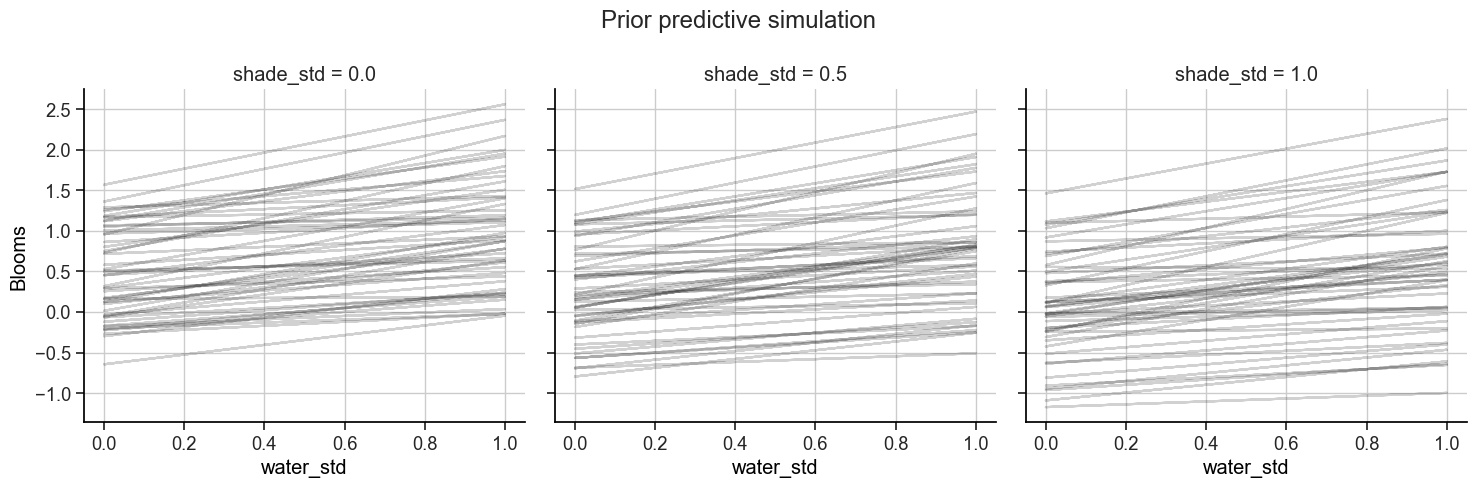

In [195]:
plot_tulips_triptych(
    prior_trace_8m4,
    group="prior",
    x_name="water_std",
    strat_name="shade_std",
    n_lines=50,
    suptitle="Prior predictive simulation",
);

Note that the the lines all have positive slope in the left plot because of the positive prior on the water coefficient and going left to right the lines generally get lower due to the negative prior on shade.
We see the opposite thing if we plot blooms against shade while keeping water constant.

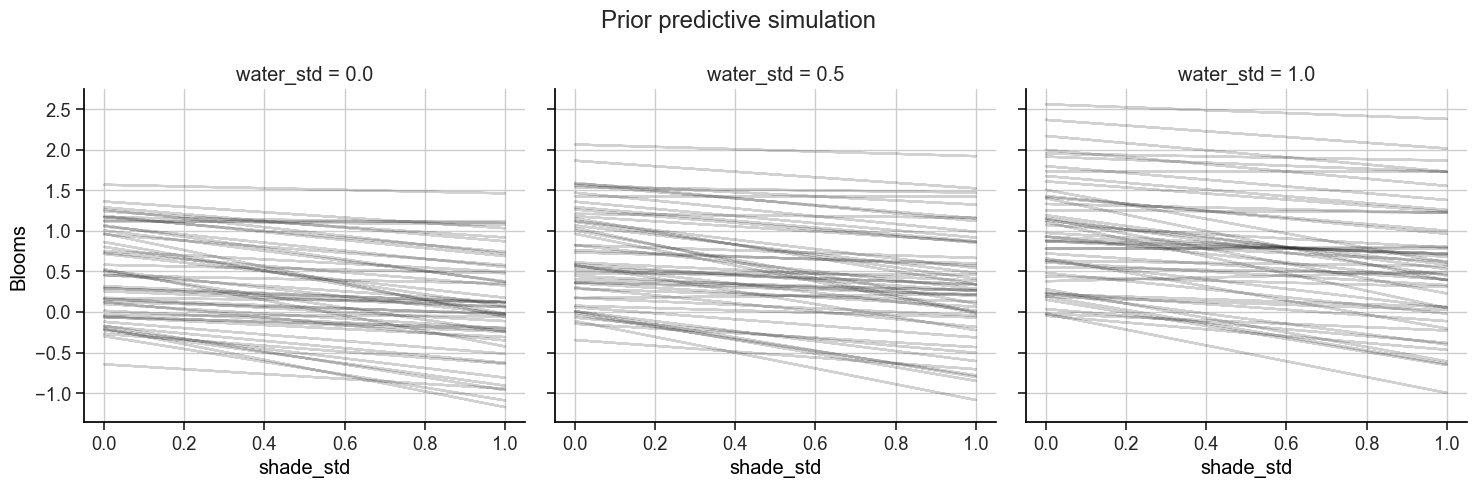

In [196]:
plot_tulips_triptych(
    prior_trace_8m4,
    group="prior",
    x_name="shade_std",
    strat_name="water_std",
    n_lines=50,
    suptitle="Prior predictive simulation",
);

Why do the slopes not all have correct sign in the centre and right plots?
This is because of the interaction term.
Recall that the interaction coefficient controls how the slope of line changes as we move from left to right.
This means that if the interaction coefficient is large enough then the sign of the slope can change.
We can resolve this by constraining $-\beta_W < \beta_{WS} < \beta_S$ in sampling:

In [210]:
with m_8m4:
    constraint = (beta_ws > -beta_w) & (beta_ws < beta_s)
    pm.Potential(
        "interaction_constraint",
        pm.math.log(pm.math.switch(constraint, 1, 0.01)),
    )
    
    # inference
    trace_8m4 = pm.sample(draws=10_000, tune=2_000, target_accept=0.95, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_w, beta_s, beta_ws, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 13 seconds.


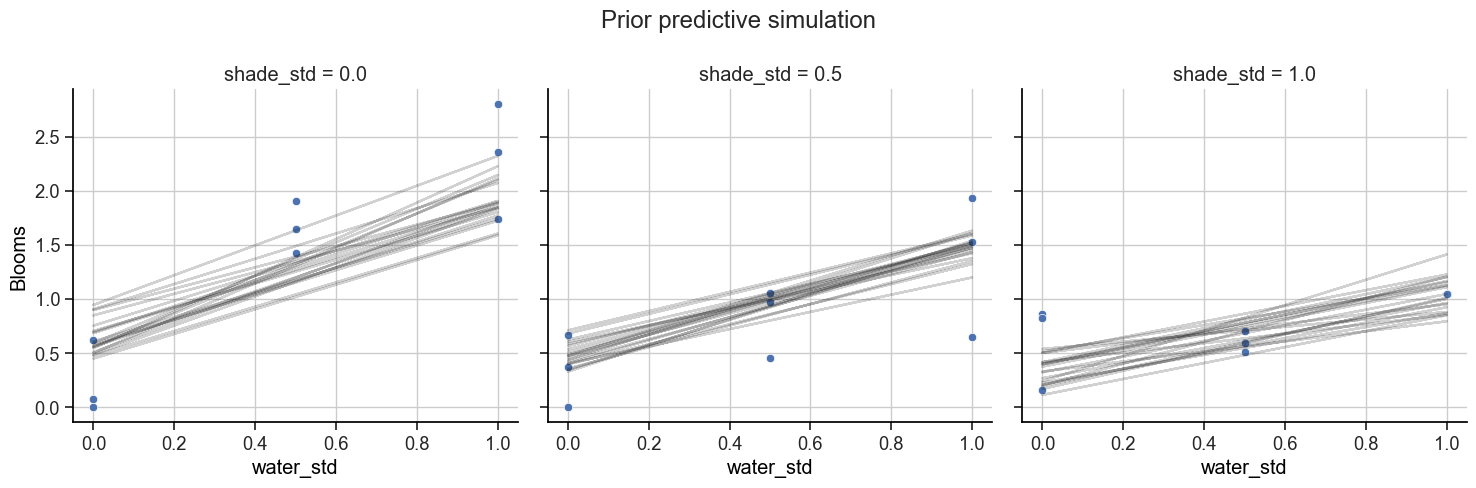

In [216]:
plot_tulips_triptych(
    trace_8m4,
    tulips=tulips,
    group="posterior",
    x_name="water_std",
    strat_name="shade_std",
    n_lines=20,
    suptitle="Prior predictive simulation",
);

Note that the the lines all have positive slope in the left plot because of the positive prior on the water coefficient and going left to right the lines generally get lower due to the negative prior on shade.
We see the opposite thing if we plot blooms against shade while keeping water constant.

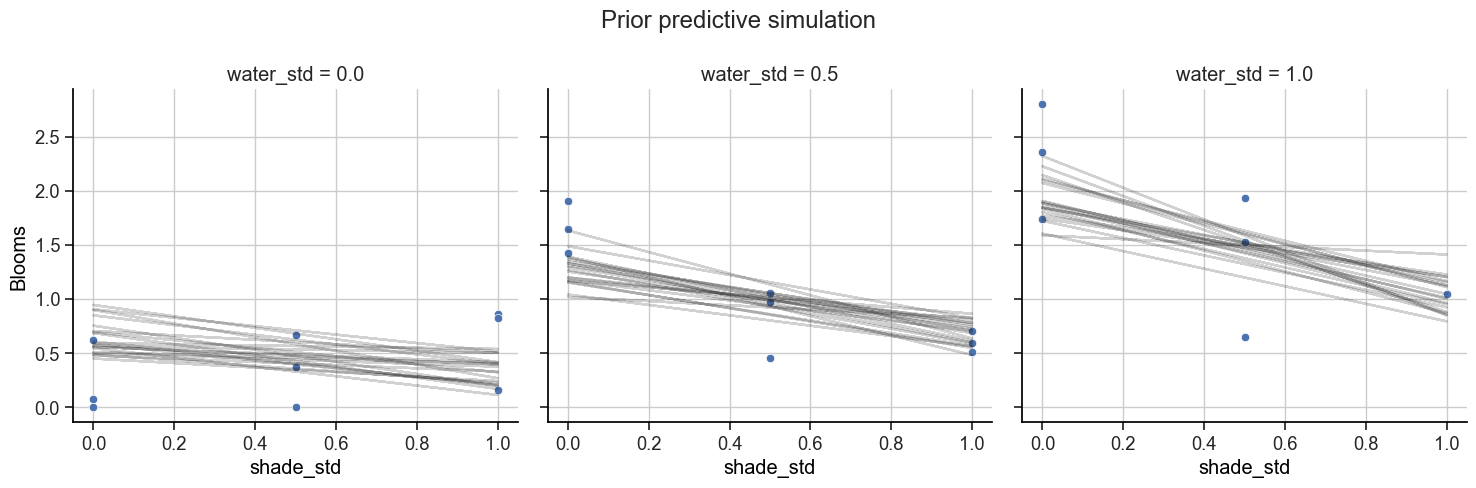

In [217]:
plot_tulips_triptych(
    trace_8m4,
    tulips=tulips,
    group="posterior",
    x_name="shade_std",
    strat_name="water_std",
    n_lines=20,
    suptitle="Prior predictive simulation",
);